# Análisis de sentimientos, afecto y connotación
**Gabriella Bollici**

El presente trabajo constituye un intento de análisis del sentimiento utilizando el enfoque del aprendizaje
automático tradicional, incluyendo fase de preparación y
preprocesamiento de los datos, fase de entrenamiento, fase de
evaluación, y fase de exploración e interpretación de los resultados
obtenidos. Comenzaré haciendo el análisis con el Clasificador Bayesiano ingenuo multinomial, para posteriormente emplear el Clasificador de máquina de vectores de soporte lineal. Finalmente, analizaré los resultados obtenidos reflexionando sobre el dataset y el modelo generado.


## 1) Clasificador Bayesiano ingenuo multinomial

  El primer paso será cargar un dataset de Huggingface adecuado para realizar un análisis de sentimientos con clasificador bayesiano ingenuo multinomial y máquinas de vectores de soporte lineales. En este caso, he escogido el dataset de car-reviews, que recoge reseñas de coches y sus puntuaciones de 1 a 5. No está dividido en entrenamiento, validación y test, pero la solución será dividirlo e incorporarle una columna "split" para poder utilizarlo.

In [ ]:
!pip install datasets evaluate transformers[sentencepiece] sacrebleu -Uq

from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset("florentgbelidji/car-reviews")

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0.1', 'Unnamed: 0', 'Review_Date', 'Author_Name', 'Vehicle_Title', 'Review_Title', 'Review', 'Rating'],
        num_rows: 36984
    })
})

Las siguientes celdas de código separan el dataset escogido en tres conjuntos de entrenamiento, validación y test, y posteriormente los convierte en dataframes de pandas y los unifica en uno solo.

In [ ]:
from datasets import load_dataset, DatasetDict
from sklearn.model_selection import train_test_split
import random

# Se crea una lista de índices para el conjunto de datos
indices = list(range(len(dataset['train'])))

# Se mezclan aleatoriamente los índices
random.shuffle(indices)

# Ahora, se crea una lista de instancias mezcladas utilizando los índices
train_instances = [dataset['train'][i] for i in indices]

# Se agregar la columna "split" con valor 0 a la lista de entrenamiento
for instance in train_instances:
    instance['split'] = 0

# Se añade un objeto DatasetDict a partir de la lista de instancias mezcladas
mixed_dataset = DatasetDict({'train': train_instances})

# Se dividen los datos en conjuntos de entrenamiento, validación y prueba
train_val_dataset, test_dataset = train_test_split(mixed_dataset['train'], test_size=0.2)
train_dataset, val_dataset = train_test_split(train_val_dataset, test_size=0.15)

# Se actualiza la columna "split" de los tres conjuntos de datos
for instance in train_dataset:
    instance['split'] = 1
for instance in val_dataset:
    instance['split'] = 2
for instance in test_dataset:
    instance['split'] = 3

# Se unen los tres onjuntos de datos en un único objeto DatasetDict
full_dataset = train_dataset + val_dataset + test_dataset

# Se imprime el tamaño de cada uno de los conjuntos de datos
print('Tamaño del conjunto de entrenamiento:', len(train_dataset))
print('Tamaño del conjunto de validación:', len(val_dataset))
print('Tamaño del conjunto de prueba:', len(test_dataset))

Tamaño del conjunto de entrenamiento: 25148
Tamaño del conjunto de validación: 4439
Tamaño del conjunto de prueba: 7397


In [ ]:
import pandas as pd

# Se convierten los datasets a dataframes de pandas
train_df = pd.DataFrame(train_dataset)
val_df = pd.DataFrame(val_dataset)
test_df = pd.DataFrame(test_dataset)

# Se agrega la columna "split" a cada uno de los dataframes
train_df['split'] = 'train'
val_df['split'] = 'val'
test_df['split'] = 'test'

# Se unen los tres en uno solo
full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# Se imprime el tamaño del dataframe completo
print('Tamaño del dataframe completo:', len(full_df))

Tamaño del dataframe completo: 36984


In [ ]:
full_df

,Unnamed: 0.1,Unnamed: 0,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating,split
0,16192,13257,on 12/23/10 21:22 PM (PST),financeman2,2011 Toyota Highlander SUV 4dr SUV AWD (3.5L 6...,We went back for seconds!!,The lease on our base model 08 AWD Highlander...,4,train
1,4302,3446,on 01/17/12 15:51 PM (PST),tex27,2012 BMW 5 Series Sedan 528i 4dr Sedan (2.0L 4...,Should Have Kept My Mazda,I really liked the new design for the 5 Serie...,4,train
2,12777,10213,on 05/26/07 00:09 AM (PDT),MIKE,2007 Toyota 4Runner SUV SR5 4dr SUV 4WD (4.0L ...,A Great Drive,Pros - a nice ride. Handles well with good ac...,5,train
3,13803,11133,on 01/24/17 08:24 AM (PST),Brenda Green,2016 Toyota 4Runner SUV Limited 4dr SUV (4.0L ...,"Loving My New ""Truck-Car"" Update 1 Year",I really enjoy driving this vehicle. I am a 5...,3,train
4,1753,1566,on 12/17/07 05:56 AM (PST),Ron E.,2007 Nissan Xterra SUV Off-Road 4dr SUV 4WD (4...,You Gotta Love It,Comfortable and capable off road vehicle. Min...,5,train
...,...,...,...,...,...,...,...,...,...
36979,8983,7032,on 11/24/03 00:00 AM (PST),JeffM,2003 BMW M3 Coupe 2dr Coupe (3.2L 6cyl 6M),Best sports car for the money,Compared to sporty sedans (Audi S4) and\rtrad...,5,test
36980,8182,6842,on 07/26/05 19:32 PM (PDT),JD,1998 Nissan Frontier Extended Cab SE 2dr Exten...,Great Truck,90K Miles & going strong. Great on and off r...,5,test
36981,1493,1212,on 04/28/17 20:39 PM (PDT),Lisa,2011 BMW X5 SUV xDrive35i Premium 4dr SUV AWD ...,Buyer Beware,This car is the biggest piece of garbage avai...,1,test
36982,10485,8823,on 01/31/10 16:25 PM (PST),College Kid,1997 Nissan Altima Sedan GXE 4dr Sedan,Best First Car Ever!,I bought this car at 16 years of age and it h...,5,test


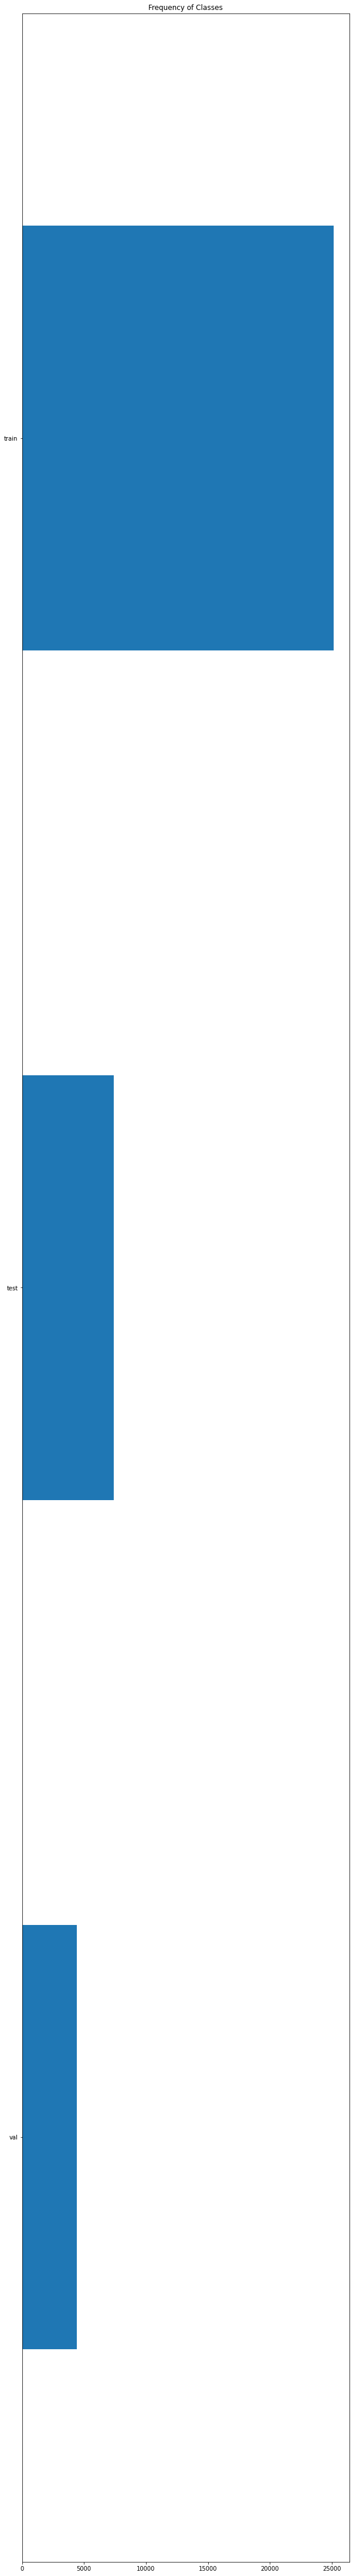

In [ ]:
# Vemos la distribución de instancias por split

import matplotlib.pyplot as plt

full_df["split"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.rcParams['figure.figsize'] = [10, 80]
plt.show()

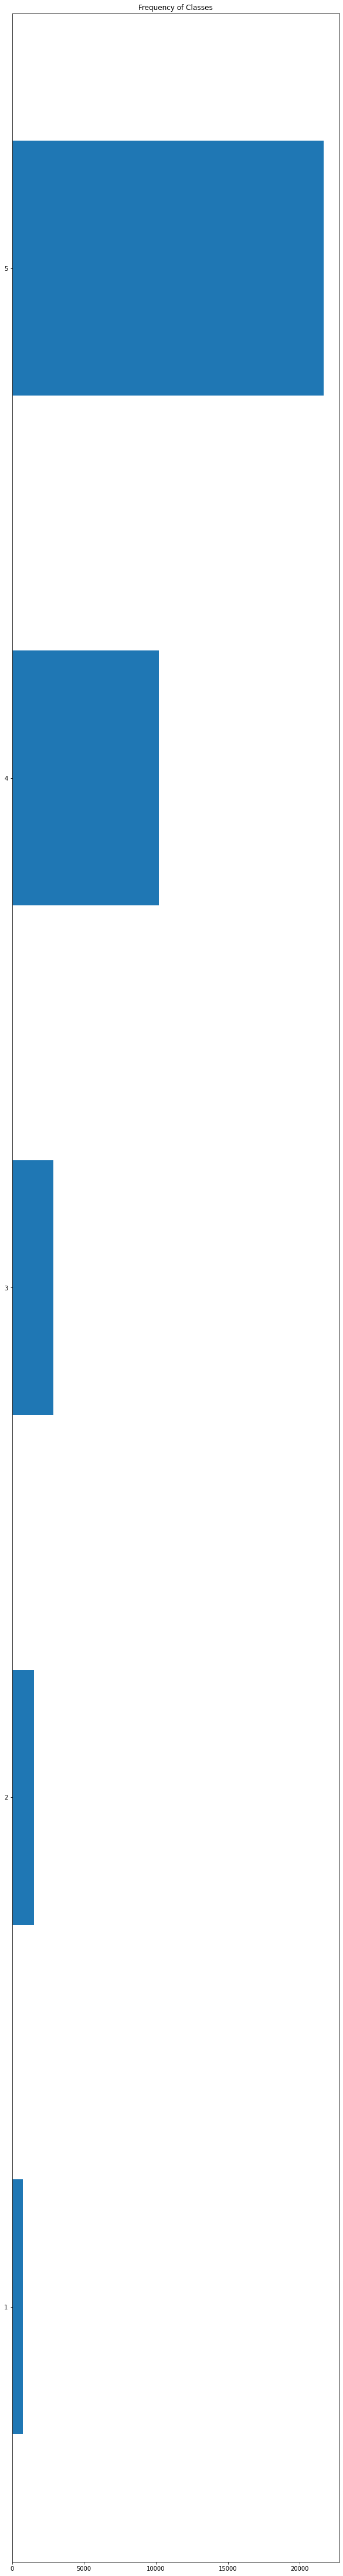

In [ ]:
# Comprobamos la distribucion de las instancias por clases (i.e. rating, puntuación)

full_df["Rating"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.rcParams['figure.figsize'] = [10, 80]
plt.show()

Vemos en la gráfica que hay un desbalance en el número de instancias de cada clase. Veremos cómo repercute eso en el desempeño del modelo. 

In [ ]:
# Nos quedamos con las columnas que nos interesan
df = full_df[['Review', 'Rating', 'split']]
df

,Review,Rating,split
0,The lease on our base model 08 AWD Highlander...,4,train
1,I really liked the new design for the 5 Serie...,4,train
2,Pros - a nice ride. Handles well with good ac...,5,train
3,I really enjoy driving this vehicle. I am a 5...,3,train
4,Comfortable and capable off road vehicle. Min...,5,train
...,...,...,...
36979,Compared to sporty sedans (Audi S4) and\rtrad...,5,test
36980,90K Miles & going strong. Great on and off r...,5,test
36981,This car is the biggest piece of garbage avai...,1,test
36982,I bought this car at 16 years of age and it h...,5,test


El siguiente paso es generar las características o features que alimenten al modelo de machine learning. Esto lo haremos empleando un vectorizador que considere las características léxicas y sintácticas que se incorporarán al modelo Naives Bayes multinomial. Lo que hace el vectorizador es convertir una colección de documentos, en este caso, una columna de texto, en una matriz numérica que sirva de entrada para un modelo de aprendizaje automático. Hay distintos tipos de vectorizador que ofrecen distintas opciones y configuraciones, como CountVectorizer, TfidfVectorizer y HashingVectorizer. Cada uno cuenta con diferentes opciones y parámetros para controlar cómo se procesa el texto y las características que se extraen. Para la tarea que nos ocupa, primero emplearemos CountVectorizer. 


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+') # Más rápido y eficiente al utilizar regex
cv = CountVectorizer(stop_words='english',ngram_range = (1,2),tokenizer = token.tokenize)

La idea es dividir otra vez el dataframe en tres, uno por cada split, y aleatorizar los datos.

In [ ]:
import random
random.seed(0)

df_train = df[df['split'] == 'train']
df_valid = df[df['split'] == 'val']
df_test = df[df['split'] == 'test']

df_train = df_train.sample(frac=1)
df_valid = df_valid.sample(frac=1)
df_test = df_test.sample(frac=1)

df_train

,Review,Rating,split
2740,"Comfort, reliability and quiet are what I wan...",5,train
2145,"So far so good, about 16.1 MPG, but that is d...",5,train
2284,I hesitated buying this Tundra due to the rel...,5,train
8209,This is my favorite car,5,train
21448,Takes about $100/year in miscellaneous repair...,4,train
...,...,...,...
6825,I purchased my 2005 with 13K miles - not perf...,4,train
21253,Squeaky windshield wipers others than that gr...,5,train
11338,Just turned 70K recently. No real problems to...,4,train
3790,We recently purchased a 2011 Toyota Sequoia. ...,4,train


En el siguiente código, la primera línea, X_train = cv.fit_transform(df_train['Review']), utiliza el objeto CountVectorizer para convertir el texto en la columna 'Review' del dataframe de entrenamiento df_train en una matriz de cuentas de tokens. También ajusta los parámetros del vectorizador a partir del texto del conjunto de entrenamiento. La segunda línea, X_valid = cv.transform(df_test['Review']), utiliza CountVectorizer para convertir el texto de 'Review' del dataframe de validación df_test en una matriz de cuentas de tokens. En este caso no se están ajustando los parámetros del vectorizador, sino que se están utilizando los parámetros ajustados previamente en el conjunto de entrenamiento. La tercera línea, X_test = cv.transform(df_test['review_body']), es similar a la segunda, salvo porquese está utilizando el texto del conjunto de evaluación en lugar del conjunto de validación. Estas líneas se utilizan para preparar los datos de texto para ser procesados por el clasificador de Naive Bayes multinomial. Las últimas tres líneas convierten las etiquetas en una matriz de etiquetas para procesarse con el clasificador de Naive Bayes multinomial.

In [ ]:
X_train = cv.fit_transform(df_train['Review'])
X_valid = cv.transform(df_valid['Review'])
X_test = cv.transform(df_test['Review'])

y_train = df_train['Rating']
y_valid = df_valid['Rating']
y_test = df_test['Rating']

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


  Usando el dataset de validación, vamos a buscar los mejores hiperparámetros. En el código que aparece a continuación, se importa la clase MultinomialNB del módulo naive_bayes de scikit-learn, que implementa el clasificador de Naive Bayes Multinomial, para clasificación de documentos en varias categorías con una matriz de cuentas de tokens. 

  En la segunda línea, se importa la clase GridSearchCV, que  implementa la búsqueda exhaustiva por rejilla para buscar los mejores hiperparámetros para un modelo mediante validación cruzada. 
  
  En la cuarta línea, clf = MultinomialNB() representa el clasificador de Naive Bayes Multinomial. 
  
  En la sexta línea, param_grid = {'alpha': [0.1, 1, 10]}, define una rejilla de hiperparámetros para la búsqueda exhaustiva por rejilla. Concretamente, se busca el mejor valor del hiperparámetro alpha, un parámetro de suavizado en Naive Bayes Multinomial. La rejilla incluye tres posibles valores para alpha: 0.1, 1 y 10. 
  
  En la séptima línea, grid_search = GridSearchCV(clf, param_grid, cv=5), se crea un objeto de la clase GridSearchCV, que representa la búsqueda exhaustiva por rejilla. Se inicializa con el clasificador clf y la rejilla de hiperparámetros param_grid, y utiliza una validación cruzada de cinco divisiones (cv=5) para la evaluación de los valores de hiperparámetros. 
  
  En la octava línea, grid_search.fit(X_train, y_train), se ajusta el objeto grid_search al conjunto de entrenamiento X_train y las etiquetas y_train, lo cual implica entrenar un modelo con cada posible combinación de hiperparámetros y evaluar el rendimiento en el conjunto de entrenamiento con validación cruzada. 
  
  Por último, print("Best hyperparameters:", grid_search.best_params_), imrpime el mejor conjunto de hiperparámetros encontrado por la búsqueda exhaustiva por rejilla, es decir, el que ha obtenido el mejor rendimiento en el conjunto de entrenamiento utilizando validación cruzada. Después, val_score = grid_search.score(X_valid, y_valid) evalúa el rendimiento del clasificador con los mejores hiperparámetros en el conjunto de validación X_valid y y_valid. El resultado se almacena en val_score, que representa la precisión del clasificador en el conjunto de validación. Para terminar, print("Validation accuracy:", val_score), imprime la precisión del clasificador en el conjunto de validación.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import numpy as np

clf = MultinomialNB()

param_grid = {'alpha': [0.1, 1, 10]}
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
val_score = grid_search.score(X_valid, y_valid)
print("Validation accuracy:", val_score)

Best hyperparameters: {'alpha': 1}
Validation accuracy: 0.6278441090335661


 Vemos que según los resultados, la precisión del clasificacdor en el conjunto de validación es de 0.63. 

 El siguiente paso es ajustar el clasificador de Naive Bayes Multinomial con el mejor conjunto de hiperparámetros encontrado en la búsqueda exhaustiva por rejilla y evaluar el rendimiento del modelo en el dataset de evaluación. Primero, clf = MultinomialNB(alpha=val_score), crea un nuevo objeto de la clase MultinomialNB con el mejor valor de alpha encontrado en la búsqueda exhaustiva por rejilla. El valor en cuestión se almacena en la variable val_score, y se pasa como argumento al constructor de MultinomialNB. Con clf.fit(X_train, y_train), se ajusta el clasificador clf al dataset de entrenamiento X_train y las etiquetas y_train, lo que implica entrenar un modelo con  el conjunto de entrenamiento y el mejor conjunto de hiperparámetros. Finalmente, test_score = clf.score(X_test, y_test), evalúa el rendimiento del clasificador en el conjunto de prueba X_test y y_test. El resultado es almacenado en la variable test_score, que representa la precisión del clasificador en el conjunto de evaluación.

In [ ]:
clf = MultinomialNB(alpha=val_score)

clf.fit(X_train, y_train)

test_score = clf.score(X_test, y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.6389076652697039


Evaluamos el macro-F1 y el F1 ponderado, así como la precisión, cobertura y F1 de cada clase.

In [ ]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       122
           2       0.25      0.00      0.01       302
           3       0.25      0.01      0.02       577
           4       0.39      0.28      0.33      2024
           5       0.70      0.95      0.81      4372

    accuracy                           0.64      7397
   macro avg       0.32      0.25      0.23      7397
weighted avg       0.55      0.64      0.57      7397



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


La cobertura para las clases es bastante dispar, debido a que hay muchos menos datos para puntuaciones de 1, 2 y 3 que para 5. Una solución sería hacer submuestreo, pero perderíamos mucha precisión. 

Una vez hecho esto, vamos a probar TfidfVectorizer para ver si obtenemos mejores resultados. Emplearé las mismas características.

TfidfVectorizer se utiliza para vectorizar documentos basándose en la frecuencia de términos (Term Frequency, TF), una medida del número de veces que un término aparece en un documento. A los términos de alta frecuencia se les da más peso, ya que se consideran más importantes.

CountVectorizer vectoriza documentos, pero sin basarse en la frecuencia de los términos. Por el contrario, se basa en la cantidad de veces que un término aparece en un documento (esto es, en un conteo). De este modo, un término con alta frecuencia en un documento recibirá el mismo peso, sin importar la longitud del documento.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english',ngram_range = (1,2),tokenizer = token.tokenize)

X_train = tfidf.fit_transform(df_train['Review'])
X_valid = tfidf.transform(df_valid['Review'])
X_test = tfidf.transform(df_test['Review'])

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

clf = MultinomialNB()

param_grid = {'alpha': [0.1, 1, 10]}
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
val_score = grid_search.score(X_valid, y_valid)
print("Validation accuracy:", val_score)

Best hyperparameters: {'alpha': 0.1}
Validation accuracy: 0.623563865735526


In [ ]:
clf = MultinomialNB(alpha=val_score)

clf.fit(X_train, y_train)

test_score = clf.score(X_test, y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.5915911856157902


In [ ]:
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       122
           2       0.00      0.00      0.00       302
           3       0.00      0.00      0.00       577
           4       0.67      0.00      0.00      2024
           5       0.59      1.00      0.74      4372

    accuracy                           0.59      7397
   macro avg       0.25      0.20      0.15      7397
weighted avg       0.53      0.59      0.44      7397



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Vemos que los resultados obtenidos con TfidfVectorizer son algo peores, ya que el report de clasificación muestra resultados de 0 para recall y f1 de 1, 2, 3 y 4. Esto se debe al sistema de Tfid Vectorizer, que da más peso a aquellos términos que más se repiten. Teniendo en cuenta que tenemos un volumen mucho mayor de reviews con una puntuación de 5 estrellas, es lógico que ocurra esto.

In [ ]:
df_test['NB_predictions'] = y_pred
df_test

,Review,Rating,split,NB_predictions,loss_values_NB,SVM_predictions
35778,I bought a used 2009 Camry LE at 176k and the...,5,test,5,0.026299,4
30190,After having had a smaller SUV I thought I wo...,4,test,5,0.036571,5
36168,"No problems in 4 years and 38,000 miles...noc...",4,test,5,0.163932,5
31049,What a quality ride! Bought it used (certifi...,5,test,5,0.067966,4
31494,"I bought this automobile 9 months ago, \rand ...",5,test,5,0.127272,4
...,...,...,...,...,...,...
35712,The Nissan Versa Hatchback is an economical c...,4,test,5,0.024793,5
36180,i bought my 2005 bmw 330xi in 2010 with 80k o...,5,test,5,0.053561,5
35920,"A land shark, one that can take a corne...",5,test,5,0.028655,5
34181,Overall the car does a great job. I live in ...,5,test,5,0.112197,4


Ahora voy a calcular los valores de pérdida, que en Naive Bayes multinomial representan la inversa de la probabilidad de la predicción correcta. A mayor valor de pérdida, menor probabilidad de una predicción correcta. Los valores de pérdida constituyen una medida de confianza en la predicción, pero no tienen por qué ser una medida de precisión. El modelo Naive Bayes multinomial es un modelo probabilístico, por lo que las predicciones se basan en la probabilidad de que una clase determinada ocurra dado un conjunto de características, así que la pérdida se calcula como 1 - probabilidad de la predicción correcta.

In [ ]:
probabilities = clf.predict_proba(X_test)
loss_values = 1 - probabilities[range(len(y_pred)), y_pred-1]

In [ ]:
df_test['loss_values_NB'] = loss_values
df_test
#df_test.sort_values(by='loss_values_NB', ascending=False, inplace=True)

,Review,Rating,split,NB_predictions,loss_values_NB,SVM_predictions
35778,I bought a used 2009 Camry LE at 176k and the...,5,test,5,0.026299,4
30190,After having had a smaller SUV I thought I wo...,4,test,5,0.036571,5
36168,"No problems in 4 years and 38,000 miles...noc...",4,test,5,0.163932,5
31049,What a quality ride! Bought it used (certifi...,5,test,5,0.067966,4
31494,"I bought this automobile 9 months ago, \rand ...",5,test,5,0.127272,4
...,...,...,...,...,...,...
35712,The Nissan Versa Hatchback is an economical c...,4,test,5,0.024793,5
36180,i bought my 2005 bmw 330xi in 2010 with 80k o...,5,test,5,0.053561,5
35920,"A land shark, one that can take a corne...",5,test,5,0.028655,5
34181,Overall the car does a great job. I live in ...,5,test,5,0.112197,4


En este caso se observan grandes valores de pérdida para predicciones correctas, lo que indica una baja probabilidad de que la predicción sea correcta. Esto pone de manifiesto el problema que supone partir de un dataset desbalanceado.

##2) Clasificador de máquina de vectores de soporte lineal



Ahora vamos a utilizar el clasificador de máquina de vectores de soporte lineal haciendo una búsqueda de los mejores hiperparámetros. La línea param_grid = {'C': [0.1, 1, 10]}, crea un diccionario que define el conjunto de hiperparámetros que se va a optimizar utilizando GridSearchCV. El diccionario solo tiene una clave, 'C', que corresponde al parámetro de regularización del modelo de SVM. El valor de esta clave es una lista de tres valores posibles para el parámetro C, [0.1, 1, 10]. Por tanto, GridSearchCV prueba tres valores diferentes para el parámetro C: 0.1, 1 y 10. La otra línea, grid_search = GridSearchCV(clf, param_grid, cv=5), crea una instancia de GridSearchCV y la almacena en la variable grid_search. Al crear la instancia, se le pasan tres argumentos: clf, el modelo que se va a optimizar, param_grid, el diccionario que define los hiperparámetros a optimizar y sus posibles valores, y cv, el número de veces que se va a dividir el conjunto de entrenamiento para validar los diferentes valores de los hiperparámetros. En este caso, se especifica que se va a utilizar una validación cruzada de k-fold con k=5.

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

clf = LinearSVC()

param_grid = {'C': [0.1, 1, 10]}
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'C': 1}


Los dos asteriscos () en la línea clf = LinearSVC(grid_search.best_params_) indican que se está utilizando la sintaxis de desempaquetado de argumentos de palabra clave (keyword arguments). De este modo, se pasa un diccionario como argumentos de una función o método, con cada clave del diccionario convirtiéndose en un argumento y cada valor convirtiéndose en el valor de ese argumento. Por otro lado, grid_search.best_params_ es un diccionario que contiene los mejores hiperparámetros encontrados por GridSearchCV, y cuando se pasan como argumentos de la función SVC con la sintaxis de desempaquetado de argumentos de palabra clave, se crea una instancia de SVC con los mejores hiperparámetros encontrados. Por ejemplo, si grid_search.best_params_ es {'C': 1}, entonces la línea clf = LinearSVC(**grid_search.best_params_) equivale a clf = LinearSVC(C=1).

In [ ]:
clf = LinearSVC(**grid_search.best_params_)
clf.fit(X_train, y_train)

test_score = clf.score(X_test, y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.6513451399215898


In [ ]:
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           1       0.30      0.08      0.13       122
           2       0.27      0.11      0.15       302
           3       0.32      0.18      0.23       577
           4       0.45      0.37      0.41      2024
           5       0.75      0.90      0.81      4372

    accuracy                           0.65      7397
   macro avg       0.42      0.33      0.35      7397
weighted avg       0.61      0.65      0.62      7397



Añadimos las predicciones hechas por el modelo al dataframe.

In [ ]:
df_test['SVM_predictions'] = y_pred
df_test

,Review,Rating,split,NB_predictions,loss_values_NB,SVM_predictions
35778,I bought a used 2009 Camry LE at 176k and the...,5,test,5,0.026299,4
30190,After having had a smaller SUV I thought I wo...,4,test,5,0.036571,5
36168,"No problems in 4 years and 38,000 miles...noc...",4,test,5,0.163932,5
31049,What a quality ride! Bought it used (certifi...,5,test,5,0.067966,4
31494,"I bought this automobile 9 months ago, \rand ...",5,test,5,0.127272,4
...,...,...,...,...,...,...
35712,The Nissan Versa Hatchback is an economical c...,4,test,5,0.024793,5
36180,i bought my 2005 bmw 330xi in 2010 with 80k o...,5,test,5,0.053561,5
35920,"A land shark, one that can take a corne...",5,test,5,0.028655,5
34181,Overall the car does a great job. I live in ...,5,test,5,0.112197,4


Para concluir, vamos a ver las predicciones con su pérdida correspondiente. Los valores de pérdida en un modelo de SVM lineal son distancia entre el punto de predicción y el límite de decisión del modelo. Si la predicción es correcta, los puntos de predicción tienen que estar muy alejados del límite de decisión para ser clasificados de manera segura en la clase correcta. Si un punto de predicción está demasiado cerca del límite de decisión, significa que el modelo está "incierto" sobre la clase a la que debe asignarlo. Cuanto mayor sea el valor de pérdida, mayor será la confianza del modelo en la predicción correspondiente.

En la siguiente línea de código se obtiene el valor de pérdida de cada predicción realizada por el modelo de SVM lineal, basándose en el conjunto de evaluación. Primero se invoca el método decision_function del objeto clf, pasándole como argumento el conjunto de prueba X_test. Se devuelve una matriz con tantas filas como elementos haya en X_test y tantas columnas como clases haya en el conjunto de entrenamiento, donde cada elemento de la matriz representa la distancia de cada elemento de X_test con el límite de decisión correspondiente a cada clase.

Después, se seleccionan las filas de la matriz que corresponden a cada predicción realizada del modelo (que se encuentran en y_pred) con el índice range(len(y_pred)), una lista con todos los índices de las filas de la matriz. Luego se seleccionan las columnas de la matriz que corresponden a cada predicción del modelo (que se encuentran en y_pred). Se hace con el índice y_pred-1, que es una lista con todos los índices de las columnas de la matriz.

Por último, se devuelve una lista con todos los elementos de la matriz seleccionados con estos índices, que representa los valores de pérdida de cada predicción realizada por el modelo de SVM lineal en el conjunto de prueba.

In [ ]:
# Calculamos la distancia de cada predicción con el límite de decisión
loss_values = clf.decision_function(X_test)[range(len(y_pred)), y_pred-1]
loss_values

array([ 0.02155408,  0.13069069, -0.14233228, ...,  0.64444608,
        0.09071545,  0.27947863])

In [ ]:
df_test

,Review,Rating,split,NB_predictions,loss_values_NB,SVM_predictions
35778,I bought a used 2009 Camry LE at 176k and the...,5,test,5,0.026299,4
30190,After having had a smaller SUV I thought I wo...,4,test,5,0.036571,5
36168,"No problems in 4 years and 38,000 miles...noc...",4,test,5,0.163932,5
31049,What a quality ride! Bought it used (certifi...,5,test,5,0.067966,4
31494,"I bought this automobile 9 months ago, \rand ...",5,test,5,0.127272,4
...,...,...,...,...,...,...
35712,The Nissan Versa Hatchback is an economical c...,4,test,5,0.024793,5
36180,i bought my 2005 bmw 330xi in 2010 with 80k o...,5,test,5,0.053561,5
35920,"A land shark, one that can take a corne...",5,test,5,0.028655,5
34181,Overall the car does a great job. I live in ...,5,test,5,0.112197,4


##  Análisis de resultados
  
  Como conclusión final, quiero resaltar la importancia de tener un buen dataset. En este caso, he tenido que dividir el dataset en entrenamiento, validación y test. Muchos datasets ya están divididos y es preferible, aunque esto concretamente no supone mucho problema. La segunda dificultad, algo mayor, ha sido la de tener una cantidad muy desigual en las clases que representaban la puntuación. Como ya mencioné, había muchos más coches con una puntuación de cinco estrellas que con una puntuación de 1 estrella. El problema se hace evidente al generarse un report de clasificación de TfidfVectorizer con unas puntuaciones de 0 para las puntuaciones de 1, 2 y 3 estrellas. Sin embargo, hacer submuestreo deriva en una pérdida enorme de precisión en el modelo. Al haber más resultados con 5 estrellas, el modelo va a predecir bastante bien reseñas con una puntuación de 5 estrellas, pero algo peor aquellas que tengan 1, 2 o 3 estrellas. Creo que, en general, hubiese sido mejor simplemente partir de un modelo donde las clases de puntuación hubiesen estado más balanceadas, ya que una buena distribución es un requisito para que un conjunto de datos sea adecuado para el ClasificadorMultinomialNB. 
